Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

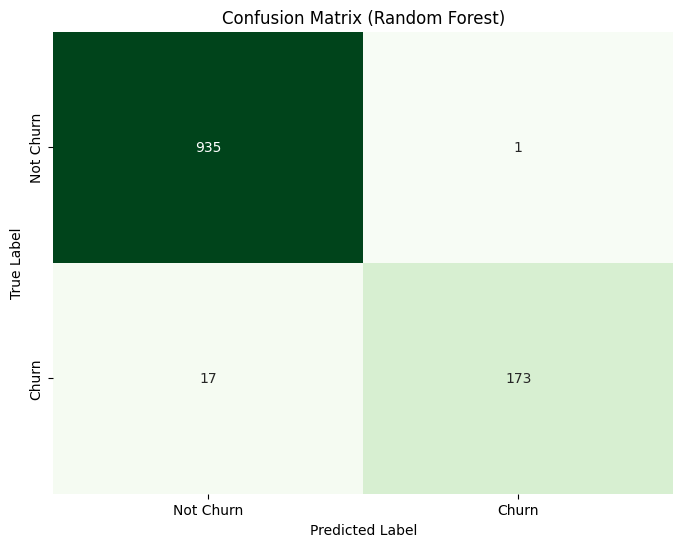


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.99      0.91      0.95       190

    accuracy                           0.98      1126
   macro avg       0.99      0.95      0.97      1126
weighted avg       0.98      0.98      0.98      1126


Feature Importance (Random Forest - Gini Importance):
                                  Feature  Importance
0                                  Tenure    0.200803
12                         CashbackAmount    0.090020
2                         WarehouseToHome    0.075396
6                         NumberOfAddress    0.063543
7                                Complain    0.062559
11                      DaySinceLastOrder    0.060632
8             OrderAmountHikeFromlastYear    0.058129
5                       SatisfactionScore    0.050992
4                NumberOfDeviceRegistered    0.037581
10                             OrderCount    0.034565


/var/folders/kw/rtpfp9xx5vj8h1n_95hjltnm0000gn/T/ipykernel_1428/1852763984.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15), palette="viridis") # Plot top 15


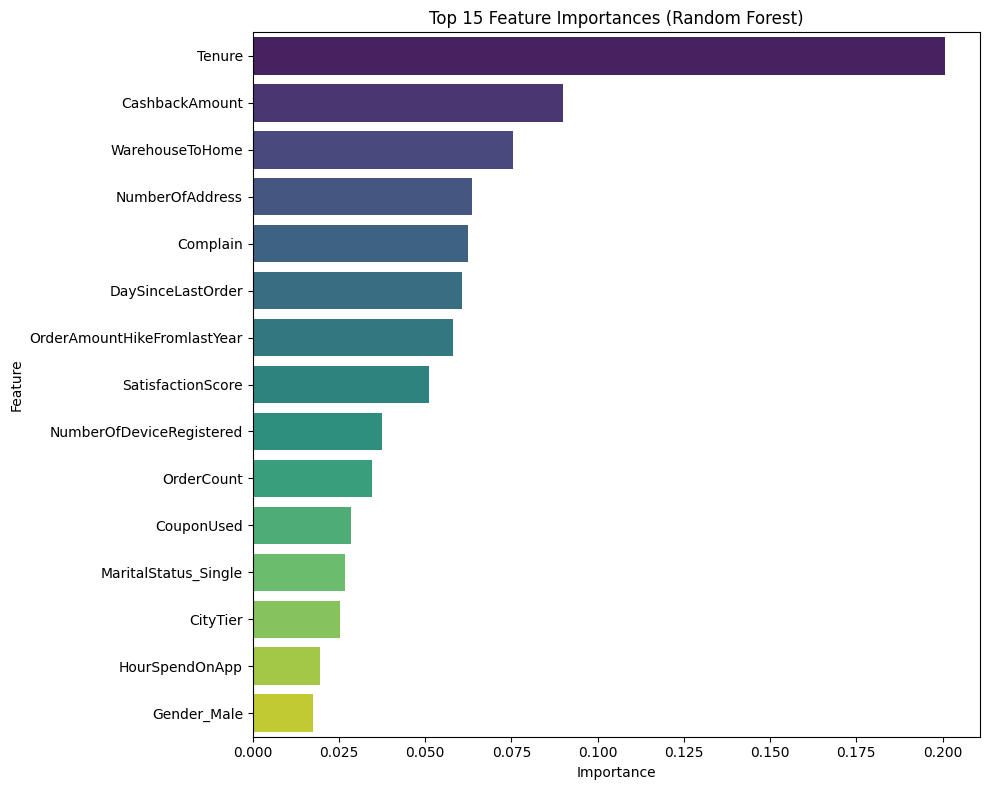

In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Changed from LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())

# Cell 3: Initial Data Exploration & Preprocessing (if dataset loaded)
if not df.empty:
    print("\nColumn Names:")
    print(df.columns)

    # Assuming 'Churn' is the target variable. Verify this based on your dataset.
    target_column = 'Churn'

    if target_column not in df.columns:
        print(f"\nError: Target column '{target_column}' not found in the dataset.")
        print("Please verify the target column name.")
    else:
        print(f"\nTarget variable: '{target_column}'")
        print(df[target_column].value_counts(normalize=True))

        if 'CustomerID' in df.columns:
            df = df.drop('CustomerID', axis=1)
            print("\nDropped 'CustomerID' column.")

        print("\nMissing values before handling:")
        print(df.isnull().sum())

        for column in df.select_dtypes(include=['object']).columns:
            df[column] = df[column].fillna(df[column].mode()[0])

        for column in df.select_dtypes(include=[np.number]).columns:
            if column != target_column:
                 df[column] = df[column].fillna(df[column].median())

        print("\nMissing values after handling:")
        print(df.isnull().sum())

        features = [col for col in df.columns if col != target_column]
        categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()
        numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

        print("\nCategorical Features:", categorical_features)
        print("Numerical Features:", numerical_features)

# Cell 4: Define Preprocessing Steps (if dataset loaded and processed)
if not df.empty and target_column in df.columns:
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)

# Cell 5: Create and Train the Random Forest Model (if X_train, y_train exist)
if 'X_train' in locals() and 'y_train' in locals():
    # Create the Random Forest pipeline
    # You can tune hyperparameters like n_estimators, max_depth, etc.
    # For example: RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))]) # n_jobs=-1 uses all processors

    print("\nTraining the Random Forest model...")
    rf_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    print("\nNote: Random Forest models can benefit from hyperparameter tuning (e.g., GridSearchCV or RandomizedSearchCV) for better performance.")

# Cell 6: Make Predictions and Evaluate the Model (if model is trained)
if 'rf_pipeline' in locals() and 'X_test' in locals():
    y_pred_rf = rf_pipeline.predict(X_test)
    y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    class_report_rf = classification_report(y_test, y_pred_rf)

    print("\nRandom Forest Model Evaluation:")
    print(f"Accuracy: {accuracy_rf:.4f}")
    print(f"ROC AUC Score: {roc_auc_rf:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix_rf)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', cbar=False, # Changed cmap for visual distinction
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Random Forest)')
    plt.show()

    print("\nClassification Report:")
    print(class_report_rf)

# Cell 7: Feature Importance (from Random Forest) (if model is trained)
if 'rf_pipeline' in locals():
    try:
        ohe_feature_names_rf = rf_pipeline.named_steps['preprocessor'] \
                                           .named_transformers_['cat'] \
                                           .get_feature_names_out(categorical_features)
        
        all_feature_names_rf = numerical_features + list(ohe_feature_names_rf)
        
        # Get feature importances from the Random Forest model
        importances = rf_pipeline.named_steps['classifier'].feature_importances_

        feature_importance_df_rf = pd.DataFrame({'Feature': all_feature_names_rf, 'Importance': importances})
        feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

        print("\nFeature Importance (Random Forest - Gini Importance):")
        print(feature_importance_df_rf)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15), palette="viridis") # Plot top 15
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nCould not display feature importance: {e}")
        print("This might happen if the pipeline structure is different or steps are named differently.")

